In [40]:
# Načtení potřebných knihoven
import numpy as np
from pysheds.grid import Grid
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import rasterio

In [41]:
# Načtení digitálního modelu terénu (DEM) z přiložené cesty
grid = Grid.from_raster('C:/Users/myska/OneDrive/Dokumenty/jup_kod/dem.tif')
dem = grid.read_raster('C:/Users/myska/OneDrive/Dokumenty/jup_kod/dem.tif')
dem_file = 'C:/Users/myska/OneDrive/Dokumenty/jup_kod/dem.tif'

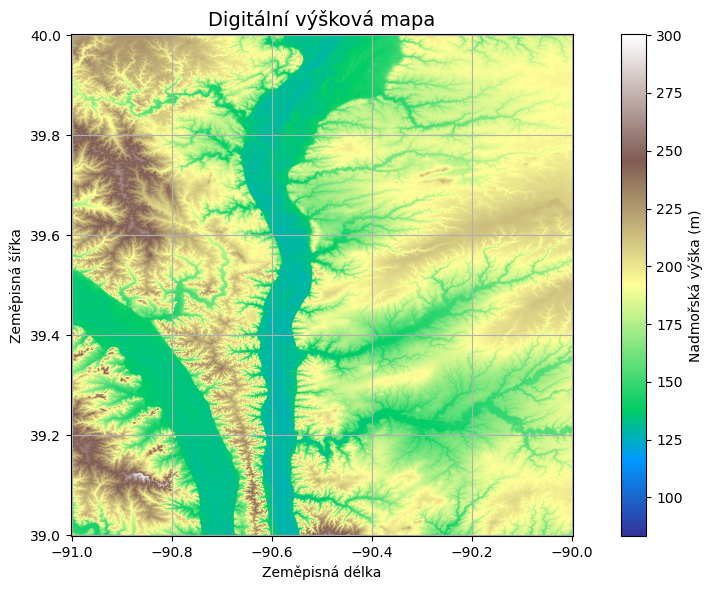

In [25]:
# Vytvoření obrázku a osy grafu a průhlednosti
fig, ax = plt.subplots(figsize=(10,6))
fig.patch.set_alpha(0)

# Zobrazení DEM s použitím barevného schématu 'terrain'
plt.imshow(dem, extent=grid.extent, cmap='terrain', zorder=1)

# Přidání legendy
plt.colorbar(label='Nadmořská výška (m)')

# Přidání mřížky
plt.grid(zorder=0)

# Popisky
plt.title('Digitální výšková mapa', size=14)
plt.xlabel('Zeměpisná délka')
plt.ylabel('Zeměpisná šířka')
plt.tight_layout()

In [26]:
# Vyplnění propadlin v digitálním modelu terénu
pit_filled_dem = grid.fill_pits(dem)

# Vyplnění depresí
flooded_dem = grid.fill_depressions(pit_filled_dem)

# Oprava plochých oblastí v digitálním modelu terénu
inflated_dem = grid.resolve_flats(flooded_dem)

In [27]:
# Definice směrů toku (flow directions)
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)

# Výpočet směrů toku na vyplněném DEM
fdir = grid.flowdir(inflated_dem, dirmap=dirmap)

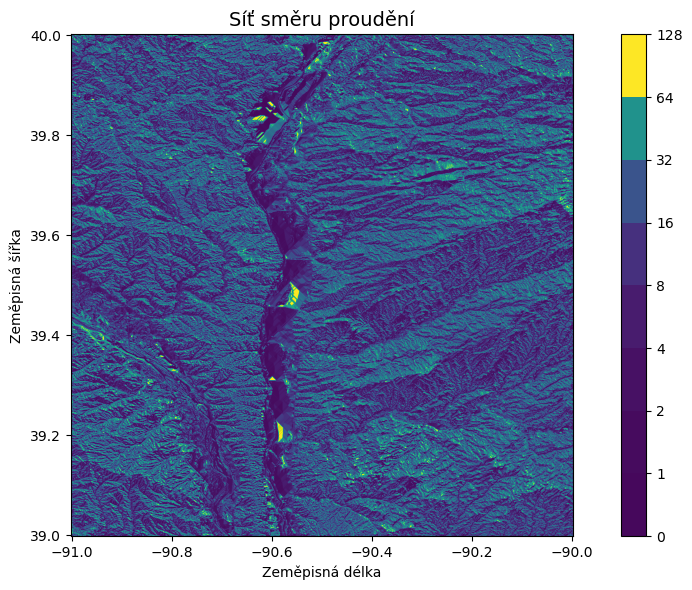

In [28]:
# Vymezení plátna a nastavení průhlednosti
fig = plt.figure(figsize=(10,6))
fig.patch.set_alpha(0)

# Zobrazení směrů toku
plt.imshow(fdir, extent=grid.extent, cmap='viridis', zorder=2)

# Legenda
boundaries = ([0] + sorted(list(dirmap)))
plt.colorbar(boundaries=boundaries, values=sorted(dirmap))

# Popisky
plt.xlabel('Zeměpisná délka')
plt.ylabel('Zeměpisná šířka')
plt.title('Síť směru proudění', size=14)
plt.grid(zorder=-1)
plt.tight_layout()


In [29]:
# Výpočet akumulace toku na základě směrů toku
acc = grid.accumulation(fdir, dirmap=dirmap)

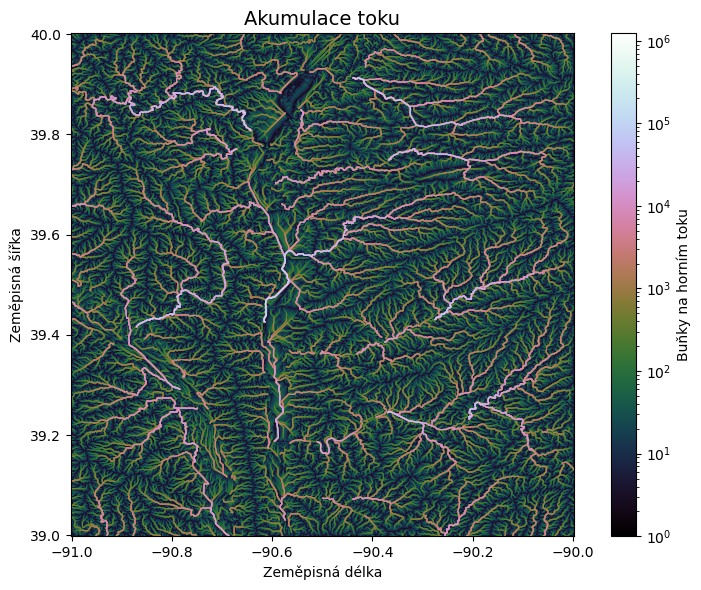

In [30]:
# Nastavení plátna a průhlednosti
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

# Přidání mřížky s pozadím
plt.grid('on', zorder=0)

# Zobrazení akumulace toku
im = ax.imshow(acc, extent=grid.extent, zorder=2,
               cmap='cubehelix',
               norm=colors.LogNorm(1, acc.max()),
               interpolation='bilinear')

# Legenda + popis
plt.colorbar(im, ax=ax, label='Buňky na horním toku')

# Popisky
plt.title('Akumulace toku', size=14)
plt.xlabel('Zeměpisná délka')
plt.ylabel('Zeměpisná šířka')
plt.tight_layout()

In [49]:
# Otevření DEM souboru
with rasterio.open(dem_file) as src:
    # Načtení dat DEM
    dem_data = src.read(1)
    
    # Zjištění minimální hodnoty nadmořské výšky
    min_elevation = dem_data.min()

'''print("Minimální hodnota nadmořské výšky v DEM:", min_elevation)'''

# Zjištění indexu minimální hodnoty nadmořské výšky
min_index = np.unravel_index(dem_data.argmin(), dem_data.shape)

# Převod indexu na zeměpisné souřadnice
x_min, y_min = src.xy(min_index[0], min_index[1])

In [50]:
# Zvolení souřadnic nejnižšího bodu v rastru
x_min, y_min

# Určení nejbližšího bodu na povrchu s akumulací toku nad 1000 buňek
x_snap, y_snap = grid.snap_to_mask(acc > 1000, (x_min, y_min))

# Vytvoření povodí pro zvolený bod (x_snap, y_snap)
catch = grid.catchment(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap, 
                       xytype='coordinate')

# Oříznutí mřížky na rozsah povodí
grid.clip_to(catch)

# Zobrazení oříznutého povodí
clipped_catch = grid.view(catch)

In [51]:
# Extrahování říční sítě
branches = grid.extract_river_network(fdir, acc > 50, dirmap=dirmap)

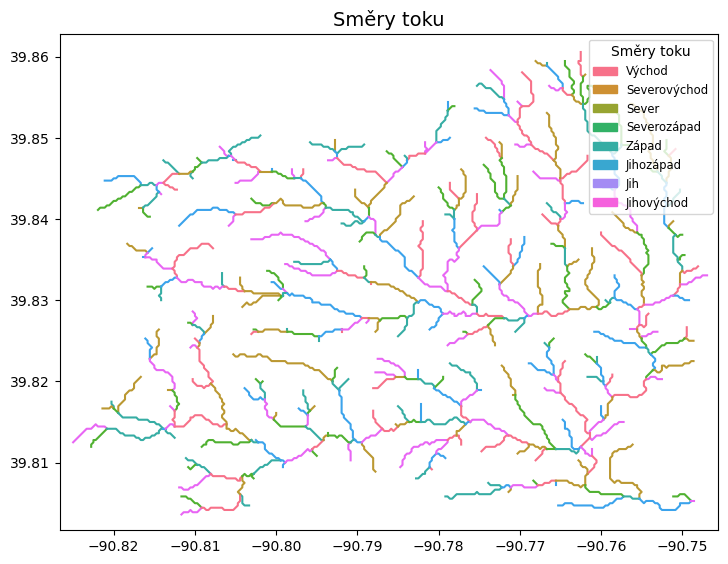

In [54]:
# Nastavení barev palety pomocí knihovny Seaborn
sns.set_palette('husl')

# Vytvoření mapy a os
fig, ax = plt.subplots(figsize=(8.5,6.5))
plt.xlim(grid.bbox[0], grid.bbox[2])
plt.ylim(grid.bbox[1], grid.bbox[3])

# Nastavení stejného měřítka na obě osy pro zachování poměru stran
ax.set_aspect('equal')

# Iterace přes jednotlivé větve říční sítě
for branch in branches['features']:
    # Extrahování souřadnic linie větve
    line = np.asarray(branch['geometry']['coordinates'])
    # Vykreslení linie
    plt.plot(line[:, 0], line[:, 1])

# Nastavení titulku grafu
_ = plt.title('Směry toku', size=14)

# Seznam barev z palety husl
colors = sns.color_palette('husl', len(dirmap_labels))

# Ruční vytvoření legendy
legend_handles = [mpatches.Patch(color=colors[i], label=dirmap_labels[i]) for i in range(len(dirmap_labels))]

# Přidání legendy do grafu s umístěním v pravém horním rohu
plt.legend(handles=legend_handles, title='Směry toku', loc='upper right', fontsize='small')


In [55]:
# Výpočet vzdálenosti od ústí do každé buňky
dist = grid.distance_to_outlet(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap,
                               xytype='coordinate')

Text(0.5, 1.0, 'Vzdálenost toku')

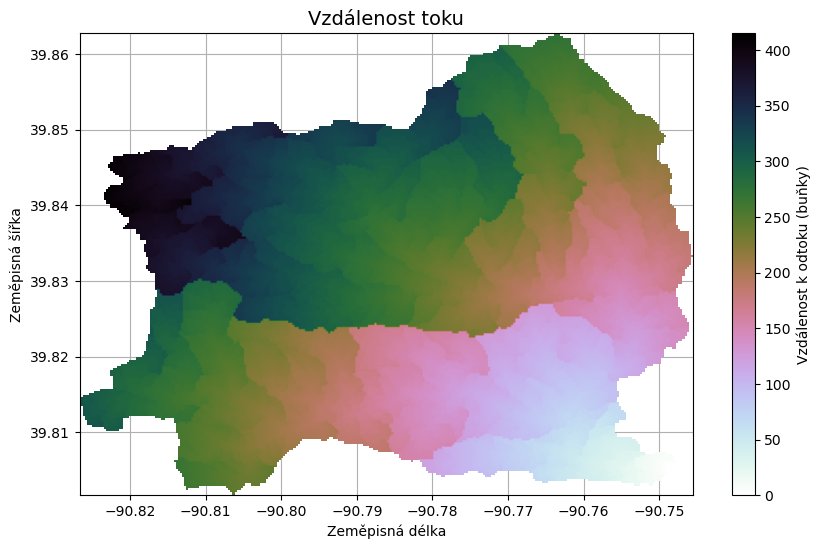

In [58]:
fig, ax = plt.subplots(figsize=(10,6))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)
im = ax.imshow(dist, extent=grid.extent, zorder=2,
               cmap='cubehelix_r')
plt.colorbar(im, ax=ax, label='Vzdálenost k odtoku (buňky)')
plt.xlabel('Zeměpisná délka')
plt.ylabel('Zeměpisná šířka')
plt.title('Vzdálenost toku', size=14)